#### model files

[audio-event-recognition/fsd-sinet/](https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/)    

!wget -q https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/fsd-sinet-vgg41-tlpf-1.pb

!wget -q https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/fsd-sinet-vgg41-tlpf-1.json


<https://mtg.github.io/essentia-labs/news/tensorflow/2023/02/08/fsdsinet-models/>
    
    tlpf : Trainable Low-Pass Filters
    aps : Adaptive Polyphase Sampling

    fsd-sinet-vgg42-tlpf_aps-1 - best
    fsd-sinet-vgg41-tlpf-1 - lighter


In [1]:
import essentia
print(essentia.__version__)
print(essentia.__file__)
import essentia.standard as es

# let's have a look at what is in there
#print(dir(essentia.standard))

import json
import matplotlib.pyplot as plt
import numpy as np
import cv2 , os

import utils.util as util
import moviepy.editor as mp

2.1-beta6-dev
/usr/local/lib/python3.8/site-packages/essentia/__init__.py


2023-04-04 23:58:13.599222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
''' HELPERS '''
#print(dir(essentia.standard))
#print(help(es.TensorflowPredictFSDSINet))

In [ ]:
'''
batchSize:
    integer ∈ [-1,inf) (default = 64)
    the batch size for prediction. This allows parallelization when GPUs are
    available. Set it to -1 or 0 to accumulate all the patches and run a single
    TensorFlow session at the end of the stream

graphFilename:
    string (default = "")
    the name of the file from which to load the TensorFlow graph

input:
    string (default = "x")
    the name of the input node in the TensorFlow graph

lastPatchMode:
    string ∈ {discard,repeat} (default = "discard")
    what to do with the last frames: `repeat` them to fill the last patch or
    `discard` them

normalize:
    bool ∈ {false,true} (default = true)
    whether to normalize the input audio signal. Note that this parameter is
    only available in standard mode

output:
    string (default = "model/predictions/Sigmoid")
    the name of the node from which to retrieve the output tensors

patchHopSize:
    integer ∈ [0,inf) (default = 50)
    number of frames between the beginnings of adjacent patches. 0 to avoid
    overlap

savedModel:
    string (default = "")
    the name of the TensorFlow SavedModel. Overrides parameter `graphFilename`
    '''

In [2]:
''' predicts per batch array while cv displaying'''
class FSDSINET():
    def __init__(self):
        
        # Loading the model
        self.graph_filename = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.pb"
        self.model = es.TensorflowPredictFSDSINet(graphFilename=self.graph_filename)

        # Read the metadata
        self.metadata_file = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.json"
        self.metadata = json.load(open(self.metadata_file, "r"))
        self.labels = self.metadata["classes"]
        self.anom_labels = ["Alarm","Boom","Crowd","Dog","Drill","Explosion","Fire","Gunshot and gunfire","Hammer","Screaming","Screech",\
                            "Shatter","Shout","Siren","Slam","Squeak","Yell"]
        self.anom_labels_i = [4,18,51,59,65,72,78,92,94,145,146,147,148,152,154,161,198]
        
        # get file list
        self.mp4_fn, *_ = util.load_xdv_test(util.SERVER_TEST_AUD_MONO_PATH)

    def plot_predictions(self, top_preds, top_labels_w_av,top_labels_with_av):
        # Generate plots and improve formatting
        matfig = plt.figure(figsize=(8, 3))
        plt.matshow(top_preds, fignum=matfig.number, aspect="auto")

        plt.yticks(np.arange(len(top_labels_w_av)), top_labels_with_av)
        locs, _ = plt.xticks()
        ticks = np.array(locs // 2).astype("int")
        plt.xticks(locs[1: -1], ticks[1: -1])
        plt.tick_params(bottom=True, top=False, labelbottom=True, labeltop=False)
        plt.xlabel("(s)")

        if self.save_plot : plt.savefig("activations.png", bbox_inches='tight')
        
    def process_rslt_all(self,predictions):
        
        def top_from_average(data, top_n):
            av = np.mean(data, axis=0)
            sorting = np.argsort(av)[::-1]
            return sorting[:top_n], [av[i] for i in sorting] ,av

        top_labels_i, averages_sorted , averages = top_from_average(predictions,self.nlabels2predict)
        top_labels = [self.labels[i] for i in top_labels_i]
        top_labels_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels, averages_sorted)]
        top_predictions = np.array([predictions[:,i] for i in top_labels_i])
        if self.plott : self.plot_predictions(top_predictions, top_labels_with_av,top_labels_with_av)

        return top_labels, top_labels_with_av
    
    def process_rslt_anom(self,predictions):
        
        def top_from_anomaly(data):
            av = np.mean(data, axis=0)
            sorting = np.argsort(av)[::-1]
            sorting_anom = [x for x in sorting if x in self.anom_labels_i]
            return sorting_anom,[av[i] for i in sorting_anom]

        top_labels_anom_i, averages_anom_sorted = top_from_anomaly(predictions)
        top_labels_anom = [self.labels[i] for i in top_labels_anom_i]
        top_labels_anom_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels_anom, averages_anom_sorted)]
        top_predictions_anom = np.array([predictions[:,i] for i in top_labels_anom_i])
        if self.plott : self.plot_predictions(top_predictions_anom, top_labels_anom_with_av,top_labels_anom_with_av)
        
        return top_labels_anom, top_labels_anom_with_av

    def predicition_complete(self,audio2predict,nlabels2predict,printt=True,plott=False,save_plot=False):
        
        self.plott = plott; self.save_plot = save_plot
        self.nlabels2predict = nlabels2predict
    
        predictions = self.model(audio2predict)
        print("predictions_shape",np.shape(predictions))

        top_labels, top_labels_with_av = self.process_rslt_all(predictions)   
        top_labels_anom, top_labels_anom_with_av = self.process_rslt_anom(predictions)     

        if printt:
            print("\nall", top_labels_with_av)
            print("\nanom", top_labels_anom_with_av)
            #for label, probability in zip(self.metadata['classes'], predictions.mean(axis=0)):
            #    print(f'{label}: {100 * probability:.1f}%') 
        
        return top_labels_with_av,top_labels_anom_with_av

    def fdspredict_from_video(self,index,path):
        
        # cv video info
        video = cv2.VideoCapture(path)
        width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        total_time = total_frames/fps
        print("total_time",total_time)
        frame_time_ms = int(1000/fps)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 0.5;thickness = 1;lineType = cv2.LINE_AA
        strap_video_name = os.path.splitext(os.path.basename(path))[0]
        wn='asVwR @ '+str(index)+strap_video_name
        cv2.namedWindow(wn) 
        
        # Extract the audio from the video
        audio = mp.AudioFileClip(filename=path)#.fx(mp.afx.audio_normalize)
        audio_total_array = audio.to_soundarray(fps=22050)
        audio_total_array_mono = np.mean(audio_total_array, axis=1)
        audio_total_array_mono_single = audio_total_array_mono.astype(np.float32)
    
        
        # predict over total array
        top,top_anom = self.predicition_complete(audio_total_array_mono_single,5,printt=False,plott=True)

        
        # predict over total saved wavfile
        #fn2 = 'audio_mono_total'+str(index)+'.wav'
        #es.MonoWriter(filename=fn2)(audio_total_array_mono_single)#sampleRate = int(22050)
        
        #audio_monoloader = es.MonoLoader(filename=fn2)()#, sampleRate=22050
        #top_n2 = predicition_complete(audio_monoloader,5)
        #print('total_wav2',top_n2,'\n\n')
        
        
        #predict over framed explosion
        #print('explosion_array000')
        #t_s=47;t_e=49 #680 
        #t_s=3;t_e=6 #675
        #audio_explosion = audio.subclip(t_start=t_s,t_end=t_e)
        #audio_explosion_array = audio_explosion.to_soundarray()
        #audio_explosion_array_mono = np.mean(audio_explosion_array, axis=1)
        #audio_explosion_array_mono_single = audio_explosion_array_mono.astype(np.float32)
        #top_n3 = self.predicition_complete(audio_explosion_array_mono_single,5,plott=True)
        #fn3 = 'audio_mono_explosion'+str(index)+'.wav'
        #es.MonoWriter(filename=fn3)(audio_explosion_array_mono_single)
        
        
        batch_len = 2*int(fps)
        batch_step_len = batch_len
        batch_steap_atual = 0
        
        batch_frame_step = 1
        atual_label0=atual_label1=atual_label2=atual_label00 = ''
         
        while True:
            
            ret, frame = video.read()
            if not ret:break
            video_atual_frame = int(video.get(cv2.CAP_PROP_POS_FRAMES))
            
            #video_atual_time = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
            #audio_frame = audio.subclip(video_atual_time , video_atual_time+(1/fps))
            #audio_frame_array = np.array(audio_frame.to_soundarray())
            
            if video_atual_frame == batch_len + batch_step_len * batch_steap_atual:
                #print(video_atual_frame)
                
                start = (batch_step_len * batch_steap_atual)/fps
                end = video_atual_frame / fps
                print(start,end)
                
                audio_batch = audio.subclip(t_start=start,t_end=end)
                audio_batch_array = audio_batch.to_soundarray()
                
                nsamples = np.shape(audio_batch_array)[0]
                secs = end-start
                sample_rate = nsamples / secs
                #print("audio_batch_array",audio_batch_array.dtype,np.shape(audio_batch_array), sample_rate)
                
                audio_batch_array_mono = np.mean(audio_batch_array, axis=1)
                audio_batch_array_mono_single = audio_batch_array_mono.astype(np.float32)
                #print("mono_single",audio_batch_array_mono_single.dtype,np.shape(audio_batch_array_mono_single))
                
                top_anom0 = self.predicition_complete(audio_batch_array_mono_single,5)
                atual_label0 = str(top_anom0[1][0])
                atual_label1 = str(top_anom0[1][1])
                atual_label2 = str(top_anom0[1][2])
                #print('batch_array',top_n0)
                
                
                # 2 save as stereo
                #es.AudioWriter(filename='audio_stereo.wav',sampleRate = int(sample_rate))(audio_batch_array)
                
                ## 1 transform stereo to mono
                #fn00 = 'audio_mono_'+str(batch_steap_atual)+'.wav'
                #es.MonoWriter(filename=fn00,sampleRate = int(sample_rate))(audio_batch_array_mono)
                #audio_monoloader = es.MonoLoader(filename=fn00, sampleRate=22050)()
                #top_n00 = predicition_complete(audio_monoloader,2)
                #atual_label00 = str(top_n00[0])
                #print('essentia',top_n00,'\n\n')
                
                
                batch_steap_atual += 1
                
            cv2.putText(frame, '%d' % (video_atual_frame)+'/'+str(int(total_frames)), (5, int(height)-7),font,fontScale,[60,250,250],thickness,lineType)    
            cv2.putText(frame,atual_label0+'\n'+atual_label1+'\n'+atual_label2+'\n'+str(batch_steap_atual),(10,15),font,fontScale,[0,0,255],thickness,lineType)  
            #cv2.putText(frame,str(atual_label00)+' '+str(batch_steap_atual),(10,30),font,fontScale,[0,0,255],thickness,lineType)  
            cv2.imshow(wn, frame)
            
            key = cv2.waitKey(frame_time_ms)  
            if key == ord('q'): break  # quit
            if key == ord(' '):  # pause
                while True:
                    key = cv2.waitKey(1)
                    if key == ord(' '):break

        video.release()
        cv2.destroyAllWindows()


def init_watch_live(watch_this):
    print("\n\nINIT WATCH LIVE")
    
    test_mp4_paths,*_ = util.load_xdv_test(util.SERVER_TEST_AUD_ORIG_PATH)
    print('\n  test_mp4_paths',np.shape(test_mp4_paths))

    test_labels_indexs = util.get_index_per_label_from_filelist(test_mp4_paths)

    fsdsinet = FSDSINET()

    print('\n  watching',watch_this)
    for labels_2_watch in watch_this:
        print('  ',labels_2_watch,' : ',test_labels_indexs[labels_2_watch])
        
        all_or_specific = input("\n\nall indxs : enter  |  specific indxs : ex 3,4,77,7  |  dry_run no as window : dr\n\n")
        
        if all_or_specific == "": # all
            for i in range(len(test_labels_indexs[labels_2_watch])):
                index = test_labels_indexs[labels_2_watch][i]
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path)
                fsdsinet.fdspredict_from_video(index,path)
        elif all_or_specific == "dr": 
            for i in range(len(test_labels_indexs[labels_2_watch])):
                index = test_labels_indexs[labels_2_watch][i]
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path) 
        else: # specific
            all_or_specific = all_or_specific.split(",")
            all_or_specific = [int(num) for num in all_or_specific]
            for index in all_or_specific:
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path)
                fsdsinet.fdspredict_from_video(index,path)


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.pb`




INIT WATCH LIVE
acc_path /raid/DATASETS/anomaly/XD_Violence/aud/testing/original

  test_mp4_paths (800,)

  get_index_per_label_from_list

	A NORMAL 300 

	B1 FIGHT 126 
	B2 SHOOT 104 
	B4 RIOT 101 
	B5 ABUSE 11 
	B6 CARACC 106 
	G EXPLOS 103 

	BG ALL ANOMALIES 500
acc_path /raid/DATASETS/anomaly/XD_Violence/aud/testing/mono

  watching ['B2']
   B2  :  [8, 9, 10, 26, 30, 36, 39, 46, 47, 49, 50, 52, 56, 57, 58, 59, 63, 64, 65, 68, 78, 79, 84, 85, 88, 92, 93, 94, 105, 109, 110, 114, 119, 126, 128, 157, 160, 163, 165, 167, 178, 184, 188, 197, 198, 201, 202, 203, 206, 208, 209, 212, 217, 221, 225, 228, 229, 230, 231, 232, 233, 235, 241, 242, 244, 251, 253, 254, 255, 258, 260, 261, 262, 265, 268, 269, 270, 274, 275, 276, 278, 279, 287, 288, 289, 291, 295, 299, 306, 309, 313, 315, 317, 324, 327, 345, 350, 351, 353, 359, 467, 606, 796, 799]

#-------------------#$%--------------------#
 B2 279 /raid/DATASETS/anomaly/XD_Violence/testing_copy/Spectre.2015__#02-02-57_02-03-27_label_B1-B2-0.

2023-04-04 23:58:42.343470: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2198820000 Hz


predictions_shape (59, 200)
0.0 2.0
predictions_shape (7, 200)

all ['Vehicle (0.663)', 'Train (0.356)', 'Rail transport (0.307)', 'Speech (0.244)', 'Human group actions (0.221)']

anom ['Explosion (0.022)', 'Squeak (0.015)', 'Crowd (0.012)', 'Boom (0.006)', 'Gunshot and gunfire (0.005)', 'Dog (0.002)', 'Fire (0.002)', 'Slam (0.002)', 'Alarm (0.002)', 'Screaming (0.001)', 'Hammer (0.001)', 'Screech (0.000)', 'Siren (0.000)', 'Drill (0.000)', 'Shout (0.000)', 'Yell (0.000)', 'Shatter (0.000)']
2.0 4.0
predictions_shape (7, 200)

all ['Vehicle (0.410)', 'Motor vehicle (road) (0.140)', 'Animal (0.113)', 'Boat and Water vehicle (0.083)', 'Explosion (0.074)']

anom ['Explosion (0.074)', 'Alarm (0.061)', 'Boom (0.023)', 'Squeak (0.016)', 'Gunshot and gunfire (0.006)', 'Siren (0.004)', 'Dog (0.003)', 'Slam (0.003)', 'Fire (0.003)', 'Crowd (0.002)', 'Hammer (0.001)', 'Drill (0.001)', 'Screaming (0.000)', 'Shout (0.000)', 'Screech (0.000)', 'Yell (0.000)', 'Shatter (0.000)']

#-----------------

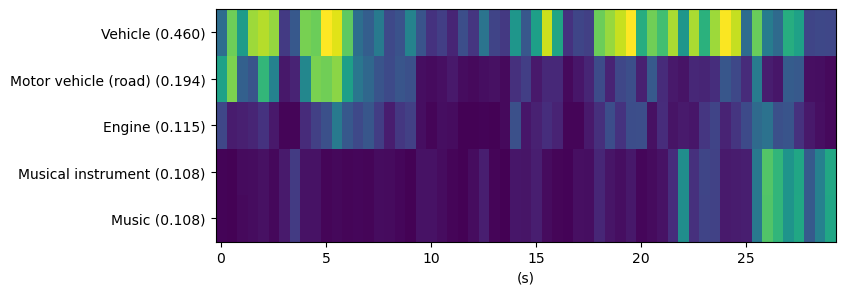

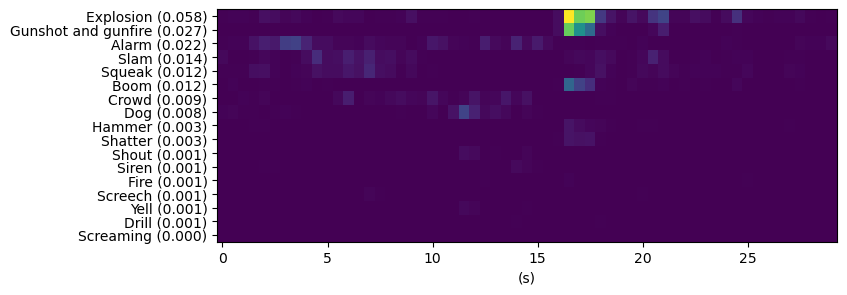

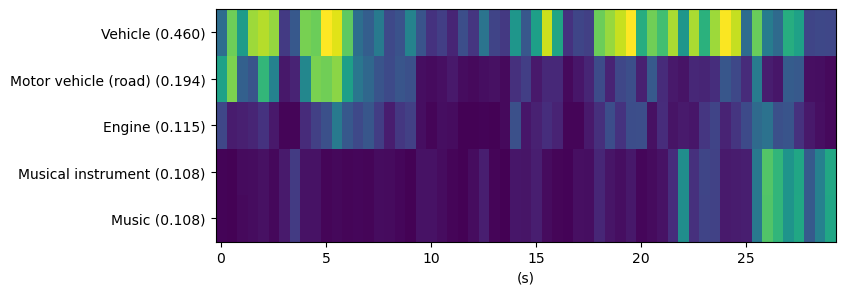

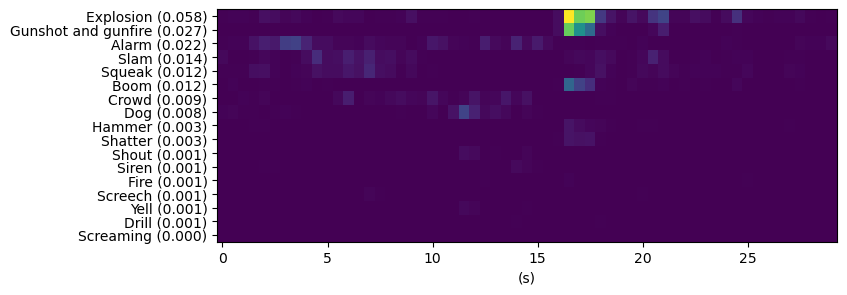

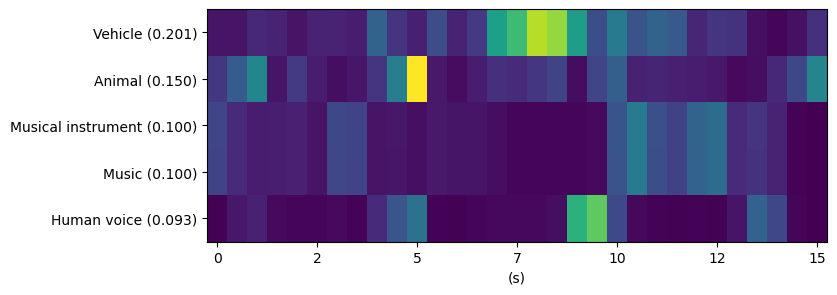

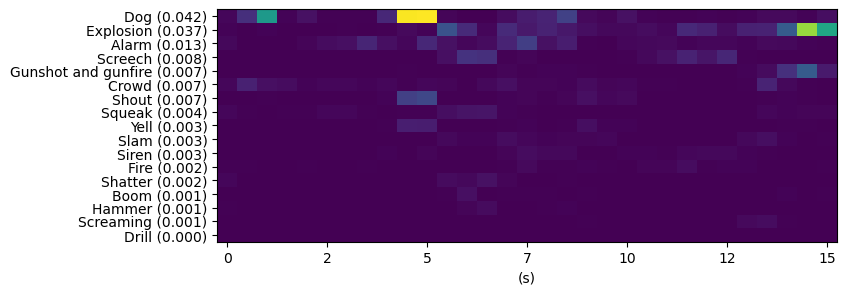

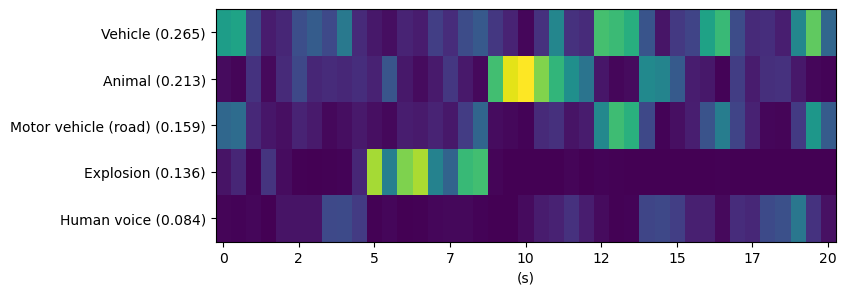

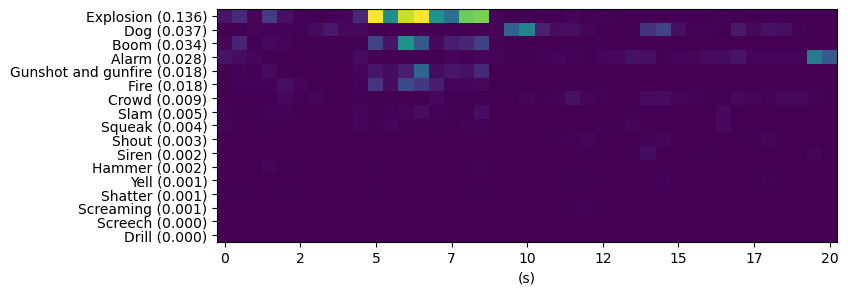

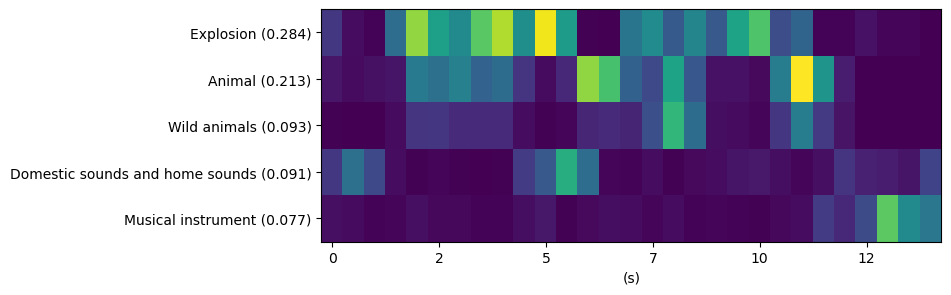

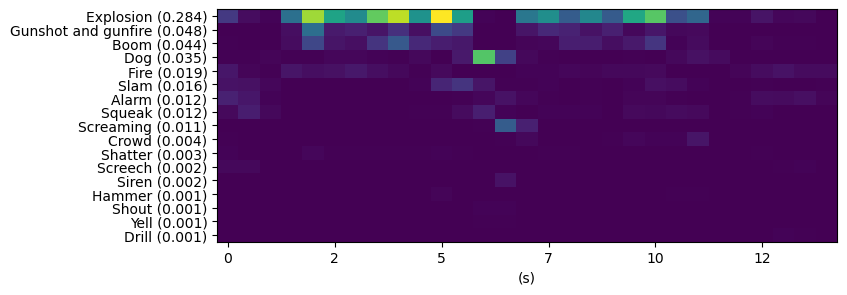

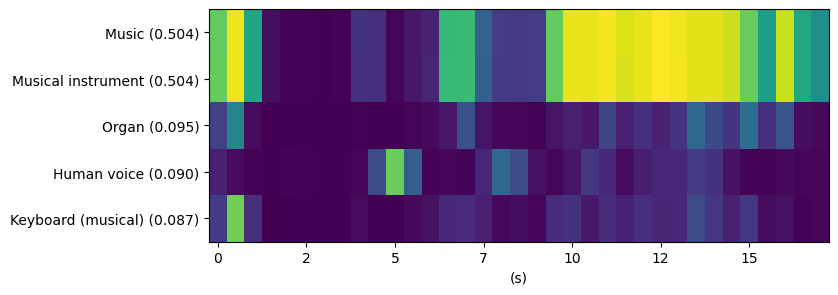

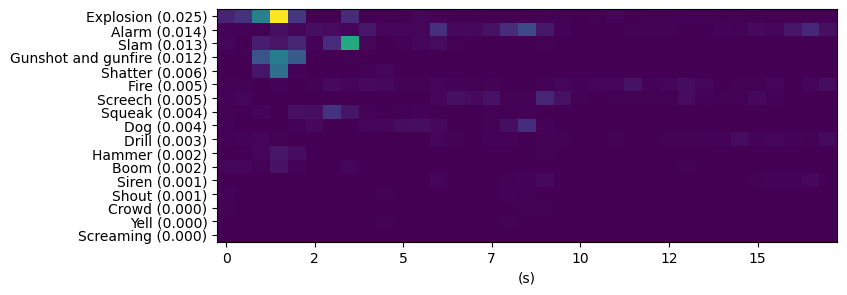

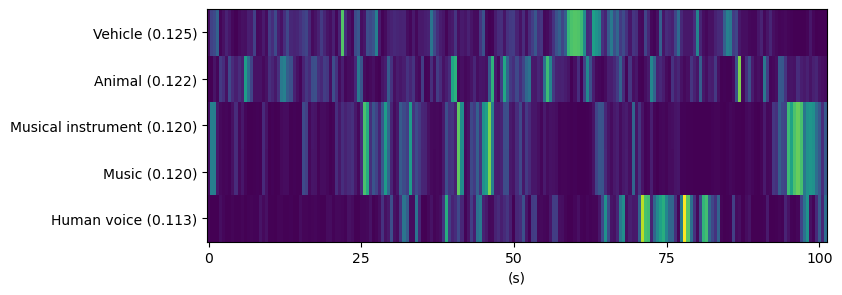

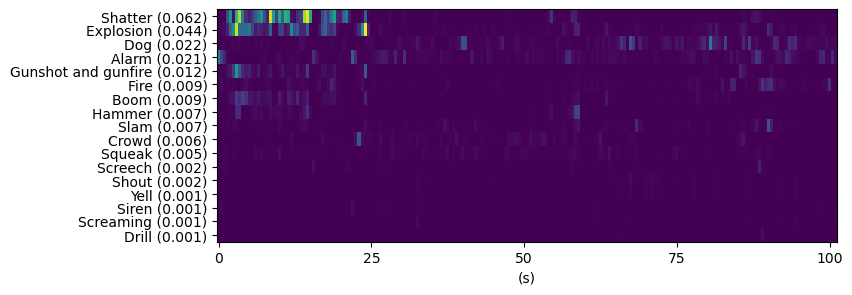

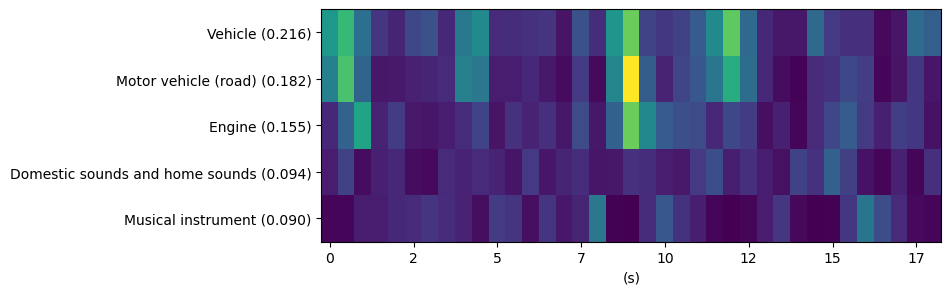

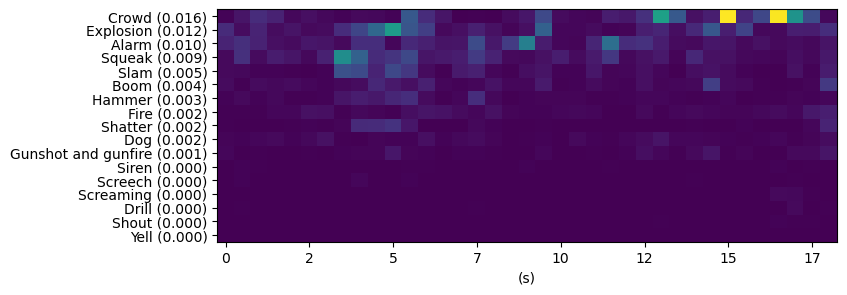

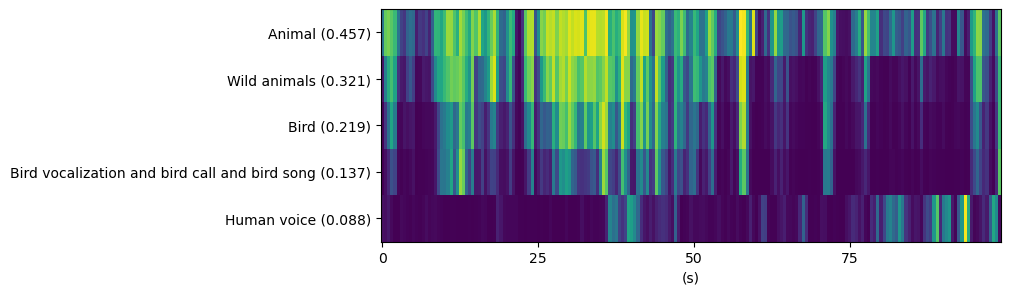

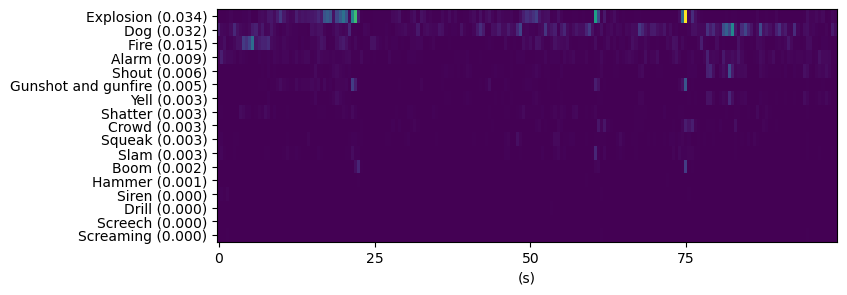

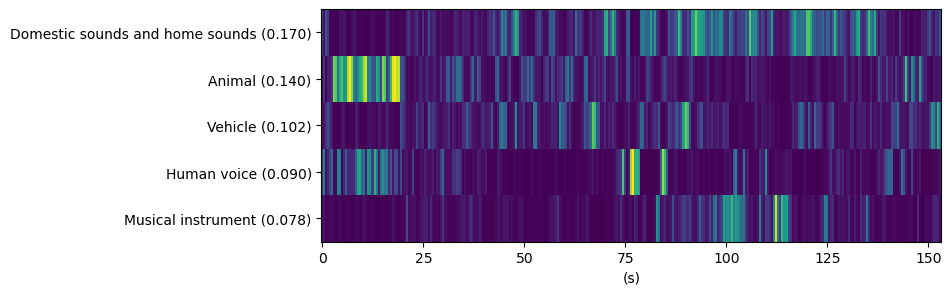

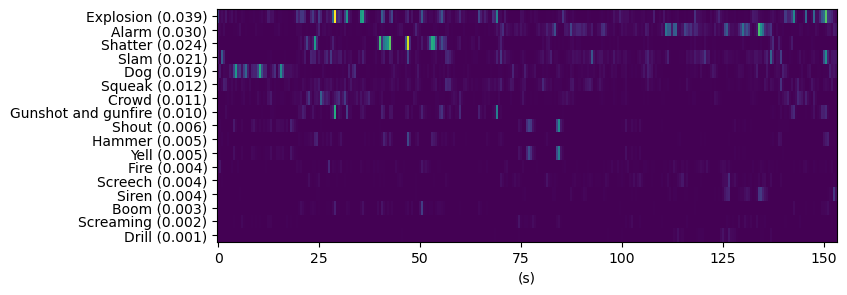

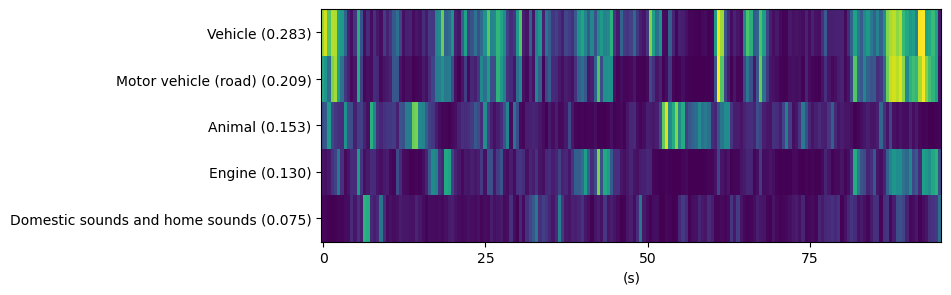

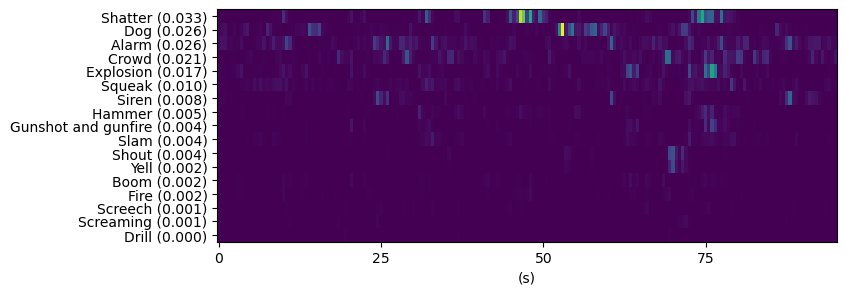

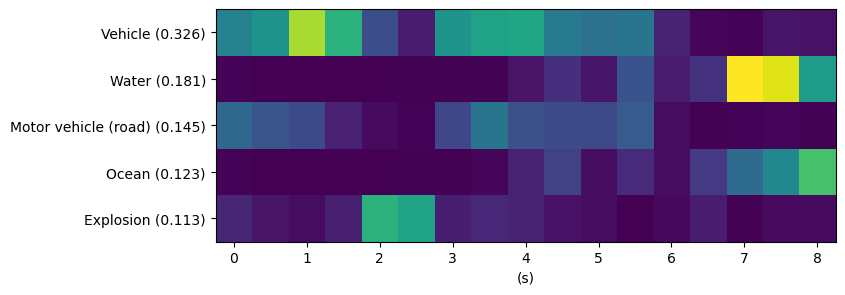

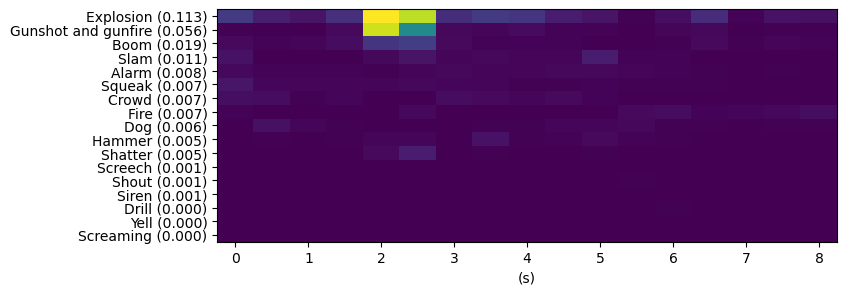

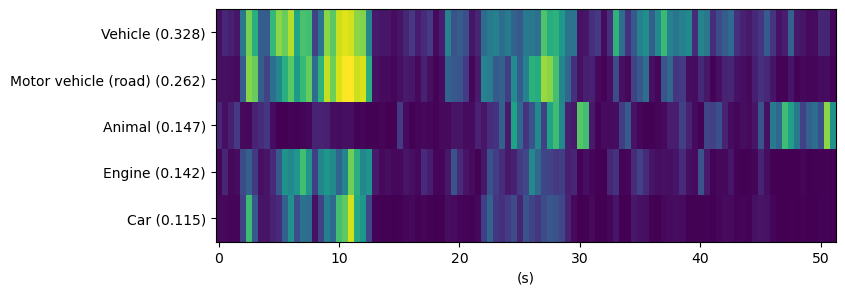

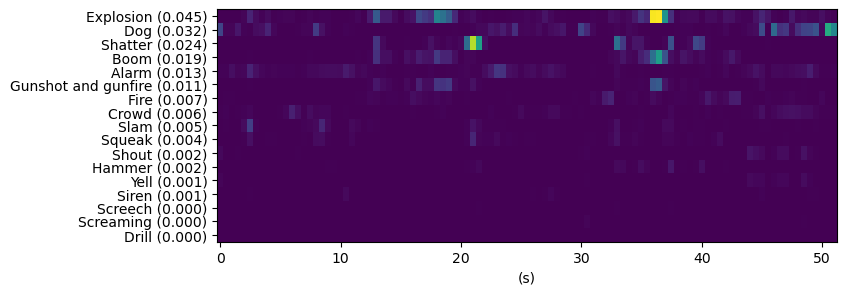

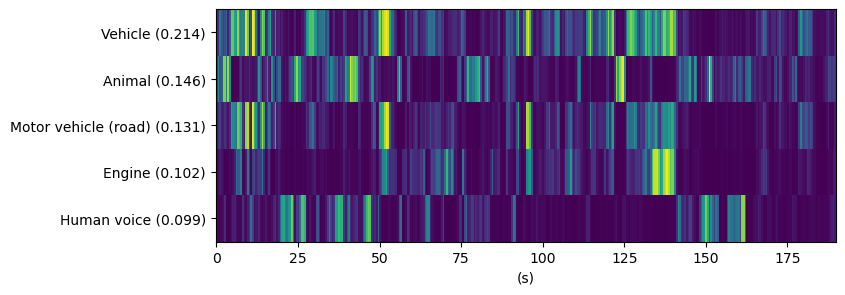

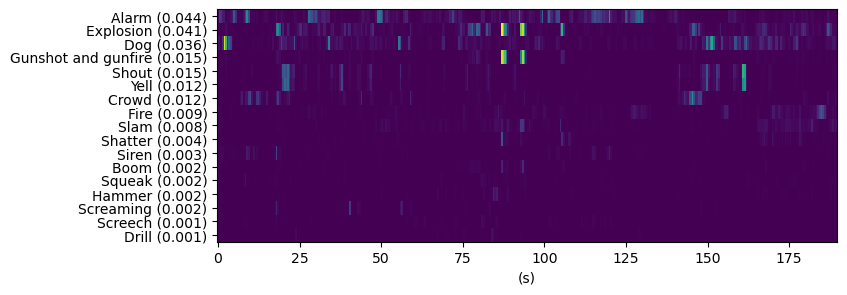

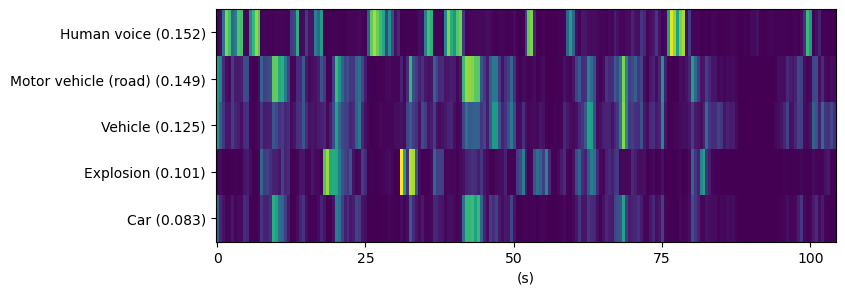

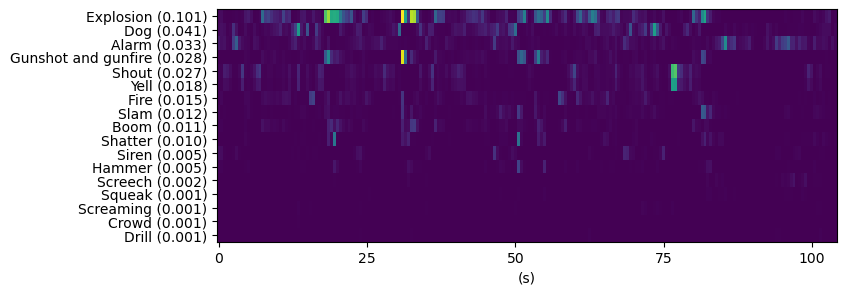

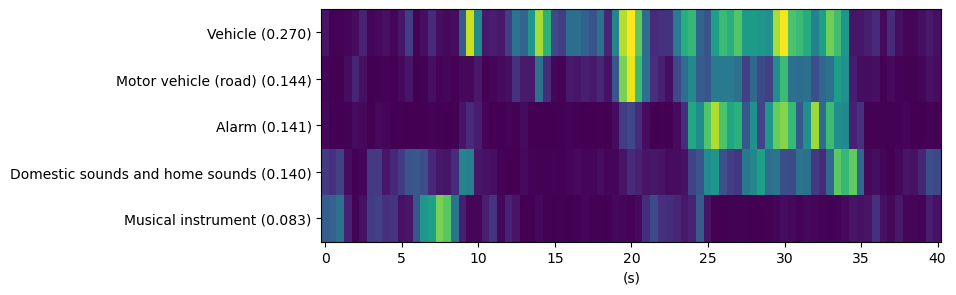

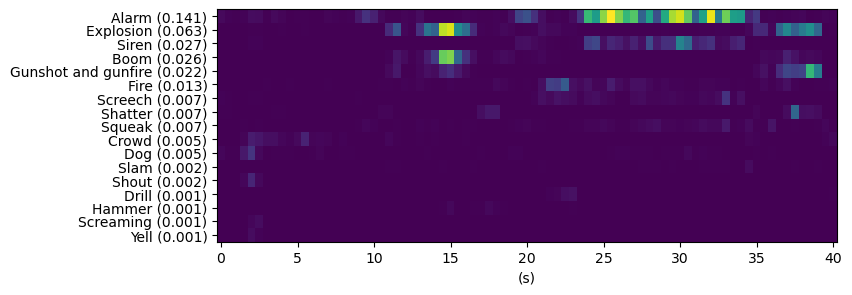

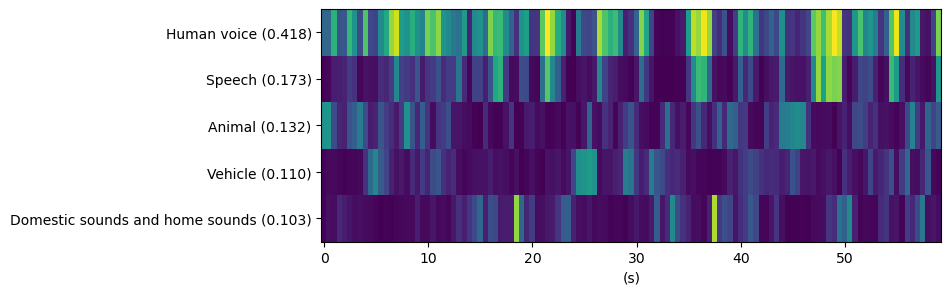

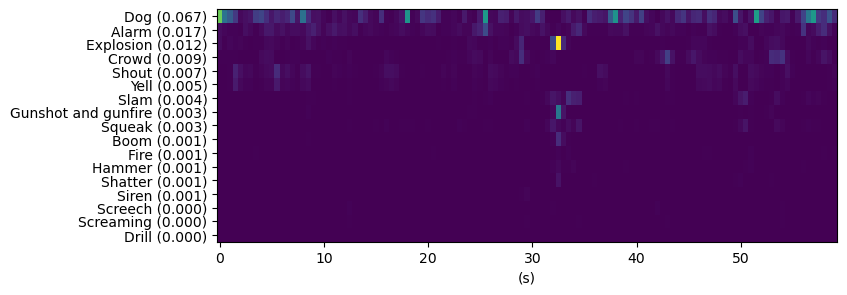

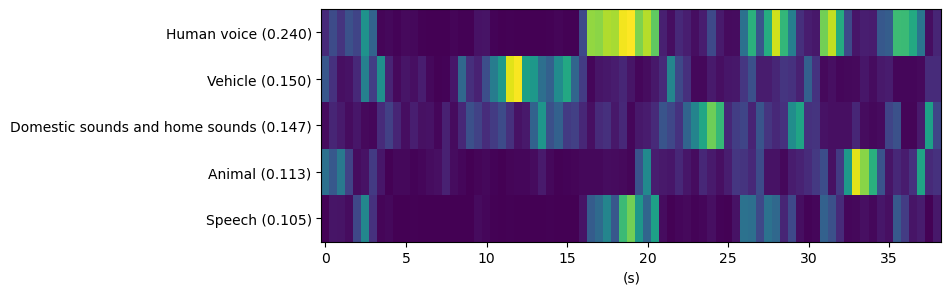

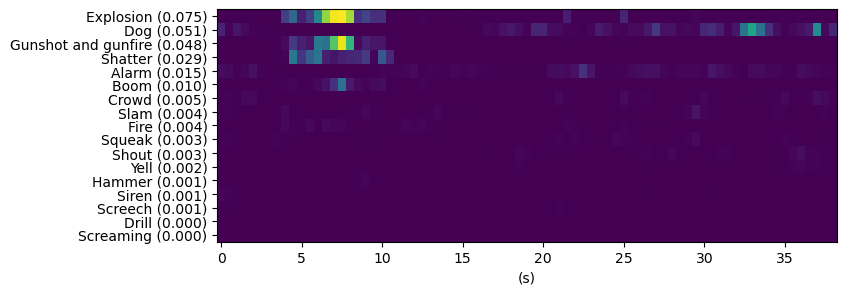

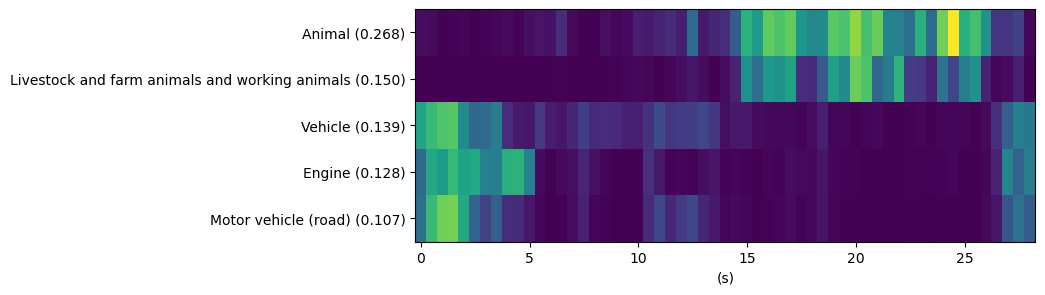

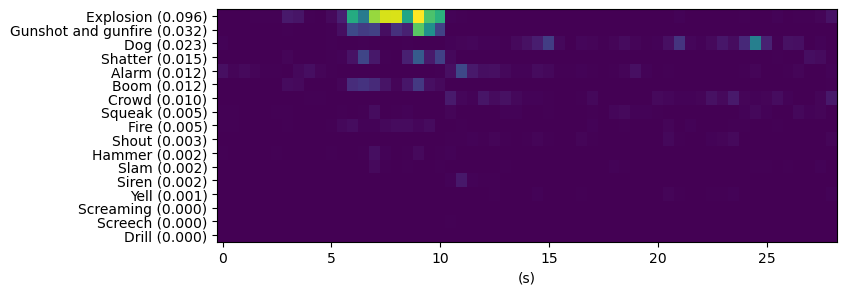

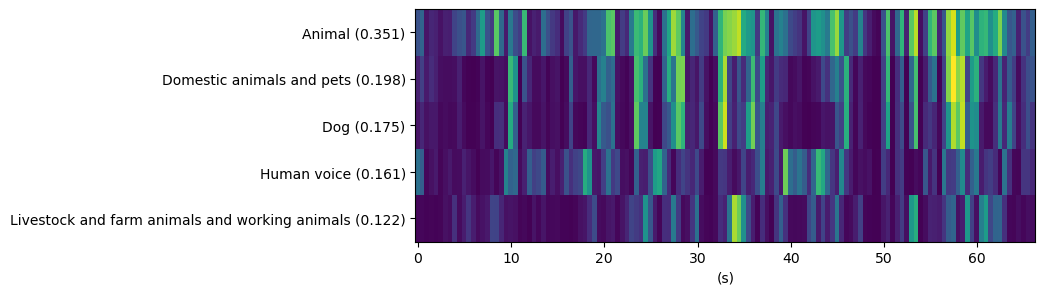

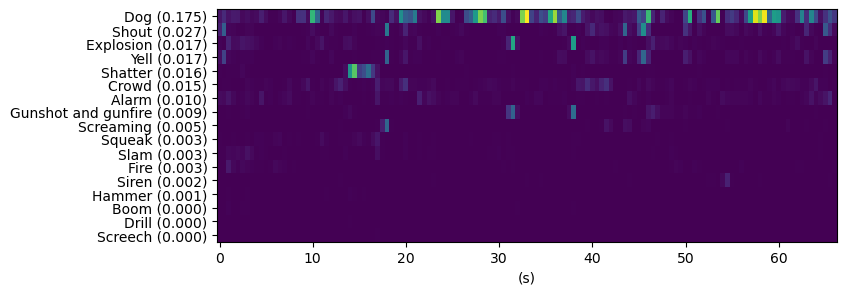

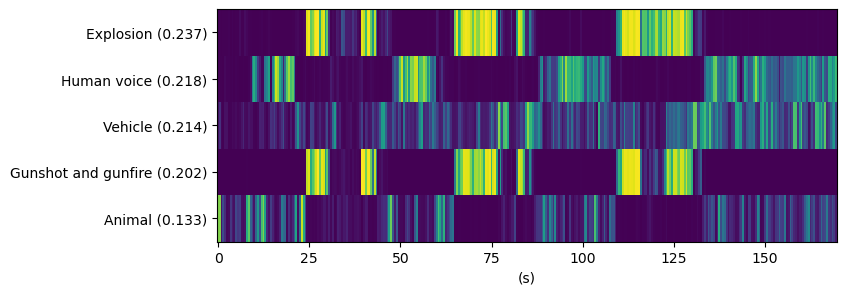

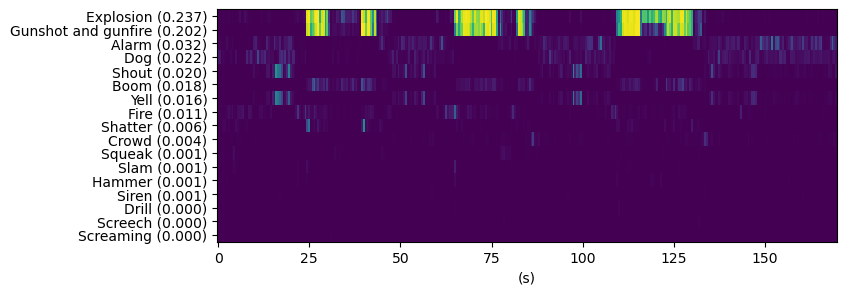

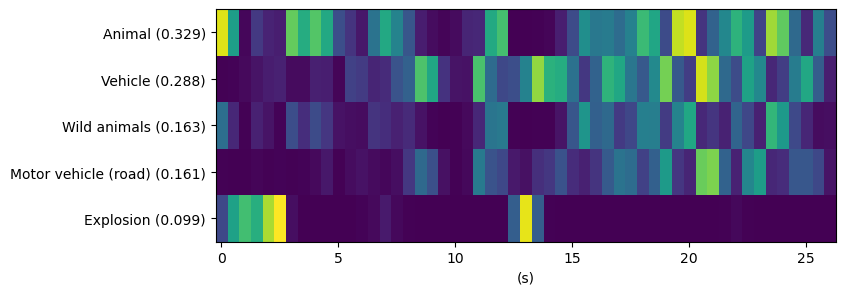

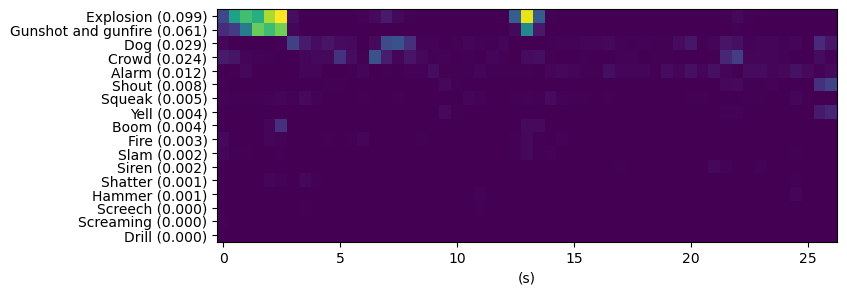

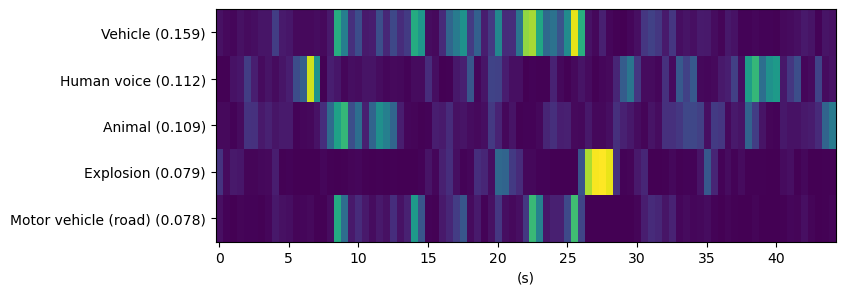

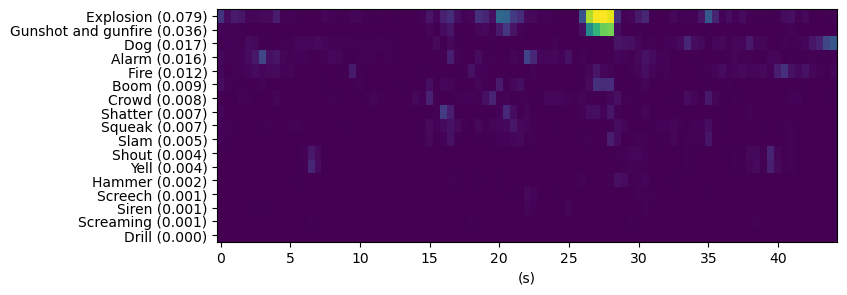

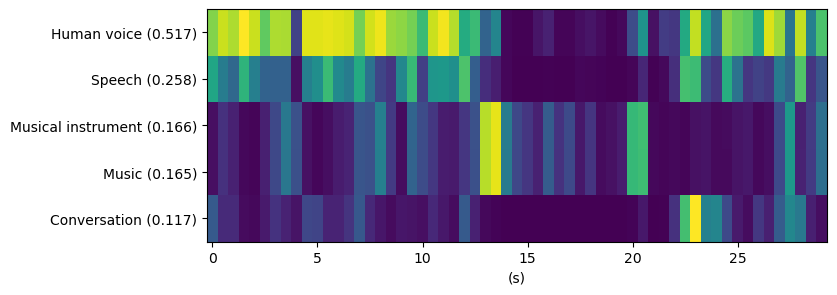

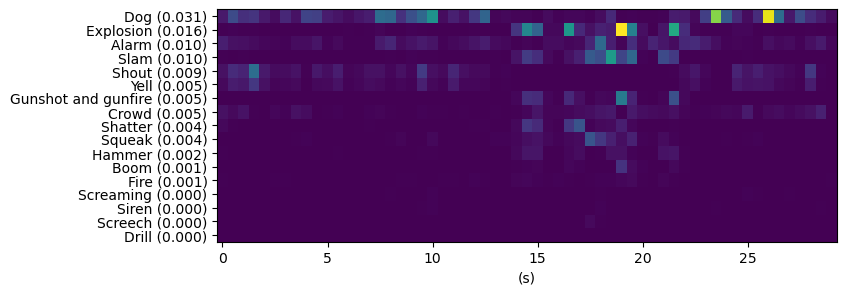

In [3]:
'''
    A  NORMAL  
    B1 FIGHT | B2 SHOOTING | B4 RIOT | B5 ABUSE | B6 CAR ACCIDENT | G  EXPLOSION 
    BG ALL ANOMALIES
'''
init_watch_live(watch_this=['B2'])

In [ ]:
''' predicts over entire audio array'''

class FSDSINET2():
    def __init__(self):
        
        # Loading the model
        self.graph_filename = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.pb"
        self.model = es.TensorflowPredictFSDSINet(graphFilename=self.graph_filename)

        # Read the metadata
        self.metadata_file = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.json"
        self.metadata = json.load(open(self.metadata_file, "r"))
        self.labels = self.metadata["classes"]
        self.anom_labels = ["Alarm","Boom","Crowd","Dog","Drill","Explosion","Fire","Gunshot and gunfire","Hammer","Screaming","Screech",\
                            "Shatter","Shout","Siren","Slam","Squeak","Yell"]
        self.anom_labels_i = [4,18,51,59,65,72,78,92,94,145,146,147,148,152,154,161,198]
        
        # get file list
        self.mp4_fn, *_ = util.load_xdv_test(util.SERVER_TEST_AUD_MONO_PATH)

    def plot_predictions(self, top_preds, top_labels_w_av,top_labels_with_av):
        # Generate plots and improve formatting
        matfig = plt.figure(figsize=(8, 3))
        plt.matshow(top_preds, fignum=matfig.number, aspect="auto")

        plt.yticks(np.arange(len(top_labels_w_av)), top_labels_with_av)
        locs, _ = plt.xticks()
        ticks = np.array(locs // 2).astype("int")
        plt.xticks(locs[1: -1], ticks[1: -1])
        plt.tick_params(bottom=True, top=False, labelbottom=True, labeltop=False)
        plt.xlabel("(s)")

        if self.save_plot : plt.savefig("activations.png", bbox_inches='tight')
        
    def process_rslt_all(self,predictions):
        
        def top_from_average(data, top_n):
            av = np.mean(data, axis=0)
            sorting = np.argsort(av)[::-1]
            return sorting[:top_n], [av[i] for i in sorting] ,av

        top_labels_i, averages_sorted , averages = top_from_average(predictions,self.nlabels2predict)
        top_labels = [self.labels[i] for i in top_labels_i]
        top_labels_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels, averages_sorted)]
        top_predictions = np.array([predictions[:,i] for i in top_labels_i])
        if self.plott : self.plot_predictions(top_predictions, top_labels_with_av,top_labels_with_av)

        return top_labels, top_labels_with_av
    
    def process_rslt_anom(self,predictions):
        
        def top_from_anomaly(data):
            av = np.mean(data, axis=0)
            sorting = np.argsort(av)[::-1]
            sorting_anom = [x for x in sorting if x in self.anom_labels_i]
            return sorting_anom,[av[i] for i in sorting_anom]

        top_labels_anom_i, averages_anom_sorted = top_from_anomaly(predictions)
        top_labels_anom = [self.labels[i] for i in top_labels_anom_i]
        top_labels_anom_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels_anom, averages_anom_sorted)]
        top_predictions_anom = np.array([predictions[:,i] for i in top_labels_anom_i])
        if self.plott : self.plot_predictions(top_predictions_anom, top_labels_anom_with_av,top_labels_anom_with_av)
        
        return top_labels_anom, top_labels_anom_with_av

    def predicition_complete(self,index,nlabels2predict,printt=True,plott=False,save_plot=False):
        
        self.plott = plott; self.save_plot = save_plot
        self.nlabels2predict = nlabels2predict
        
        path = self.mp4_fn[index]
        print("PATH",path)
        
        # Extract the audio from the video
        audio = mp.AudioFileClip(filename=path)#.fx(mp.afx.audio_normalize)
        audio_total_array = audio.to_soundarray(fps=22050)
        audio_total_array_mono = np.mean(audio_total_array, axis=1)
        audio_total_array_mono_single = audio_total_array_mono.astype(np.float32)
        audio2predict = audio_total_array_mono_single
        
        predictions = self.model(audio2predict)
        print("predictions_shape",np.shape(predictions))

        top_labels, top_labels_with_av = self.process_rslt_all(predictions)   
        top_labels_anom, top_labels_anom_with_av = self.process_rslt_anom(predictions)     


        if printt:
            print("\nall", top_labels_with_av)
            print("\nanom", top_labels_anom_with_av)
            #for label, probability in zip(self.metadata['classes'], predictions.mean(axis=0)):
            #    print(f'{label}: {100 * probability:.1f}%') 

def init_watch_live2(watch_this):
    print("\n\nINIT WATCH LIVE")
    
    test_mp4_paths,*_ = util.load_xdv_test(util.SERVER_TEST_AUD_ORIG_PATH)
    print('\n  test_mp4_paths',np.shape(test_mp4_paths))

    test_labels_indexs = util.get_index_per_label_from_filelist(test_mp4_paths)

    fsdsinet = FSDSINET2()
    
    print('\n  watching',watch_this)
    for labels_2_watch in watch_this:
        print('  ',labels_2_watch,' : ',test_labels_indexs[labels_2_watch])
        
        all_or_specific = input("\n\nall indxs : enter  |  specific indxs : ex 3,4,77,7  |  dry_run no as window : dr\n\n")
        
        if all_or_specific == "": # all
            for i in range(len(test_labels_indexs[labels_2_watch])):
                index = test_labels_indexs[labels_2_watch][i]
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path)
                fsdsinet.predicition_complete(index,15,plott=True)
        elif all_or_specific == "dr": 
            for i in range(len(test_labels_indexs[labels_2_watch])):
                index = test_labels_indexs[labels_2_watch][i]
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path) 
        else: # specific
            all_or_specific = all_or_specific.split(",")
            all_or_specific = [int(num) for num in all_or_specific]
            for index in all_or_specific:
                path = test_mp4_paths[index]
                print('\n#-------------------#$%--------------------#\n',labels_2_watch,index,path)
                fsdsinet.predicition_complete(index,15,plott=True)


In [ ]:
'''
    A  NORMAL  
    B1 FIGHT | B2 SHOOTING | B4 RIOT | B5 ABUSE | B6 CAR ACCIDENT | G  EXPLOSION 
    BG ALL ANOMALIES
'''

init_watch_live2(watch_this=['G'])